In [ ]:
import tensorflow as tf
import glob
import shutil
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from sklearn.metrics import accuracy_score 
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
base_dir='/content/drive/MyDrive/bostezos'
classes = ['no_bostezo', 'si_bostezo']  

In [ ]:
for cl in classes:
  img_path = os.path.join(base_dir, cl) # añade la carpeta de imagenes imgpath con la vairable cl que son las clases
  images = glob.glob(img_path + '/*.jpg') # glob busca todos los archivos jpg contenidos en imgpath
  print("{}: {} Images".format(cl, len(images)))# imprime la clase con la cantidad de imagenes
  num_train = int(round(len(images)*0.8)) # saca el 80% de las imagenes para train
  train, val = images[:num_train], images[num_train:]# acomoda el 80% en train y el 20 en val

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):# si no existe el directorio train
      os.makedirs(os.path.join(base_dir, 'train', cl)) # crearlo a partir de la carpeta basedir
    shutil.copy(t, os.path.join(base_dir, 'train', cl))# shutil permite hacer operaciones con archivos como copiar y mover

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

no_bostezo: 559 Images
si_bostezo: 560 Images


In [ ]:
train_dir = os.path.join(base_dir, 'train') #añade lo que hay en train a traindir
val_dir = os.path.join(base_dir, 'val')

In [ ]:
test_dir='/content/drive/MyDrive/prueba_bostezo'

In [ ]:
import keras
from keras.applications import Xception

Mobile = Xception(weights = 'imagenet', include_top = False, input_shape = (480,480,3))


In [ ]:
# for layer in Mobile.layers:
#   layer.trainable = False

for layer in Mobile.layers[1:80]:
  layer.trainable = False

In [ ]:
x=Mobile.output
x=GlobalAveragePooling2D()(x)  
x=Dropout(0.2)(x)  ###dropout agregado 
x = Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x) 
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation
model = Model(inputs = Mobile.input, outputs = preds)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 239, 239, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 239, 239, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 239, 239, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
print(len(Mobile.layers[1:40]))

39


In [ ]:
model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='adam',
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#             metrics=['accuracy'])


#lr = 0.001
#optim = keras.optimizers.Adam(learning_rate=lr)

#model.compile(optimizer=optim,
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             #loss = "categorical_crossentropy",
#             metrics=['accuracy'])
#print(model.summary())

In [ ]:
#model.summary()

In [ ]:
IMG_SHAPE = 480
batch_size = 8

train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    horizontal_flip=True,
                    shear_range=0.2,   ## se le agrego
                    zoom_range=0.2
                    )
train_data_gen = train_image_generator.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True, #deja los datos en el orden en que estan
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='binary' #tipo de clasificacion que se quiere
                                                )
 
validation_image_generator = ImageDataGenerator(rescale=1./255) 
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='binary') 

                                                                                                  

Found 895 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


In [ ]:
test_image_generator = ImageDataGenerator(rescale=1./255)               
test_data_gen = test_image_generator.flow_from_directory(batch_size=215,
                                                              directory=test_dir,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='binary')  

Found 204 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

step_size_train=train_data_gen.n//train_data_gen.batch_size

checkpoint_filepath = '../content/modelobostezos.h5'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),
    
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=4,
        verbose=1,  
        min_lr=1e-12),
        
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        #filepath='model20-12-2020_dp03031024.h5', 
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1, 
        save_best_only=True)
] 


history = model.fit(train_data_gen,
                   steps_per_epoch=step_size_train,
                   validation_data = val_data_gen,
                   callbacks=callbacks_list,
                   epochs=80)   ##estaban en 15 

# target_dir = './modelo/'
# if not os.path.exists(target_dir):
#   os.mkdir(target_dir)
model.save('../content/modelobostezos.h5')

Epoch 1/80
111/111 [==============================] - 65s 555ms/step - loss: 0.6945 - accuracy: 0.5058 - val_loss: 17.3386 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ../content/modelobostezos.h5
Epoch 2/80
111/111 [==============================] - 61s 551ms/step - loss: 0.3603 - accuracy: 0.8339 - val_loss: 1.6247 - val_accuracy: 0.8929

Epoch 00002: val_accuracy improved from 0.50000 to 0.89286, saving model to ../content/modelobostezos.h5
Epoch 3/80
111/111 [==============================] - 60s 541ms/step - loss: 0.1327 - accuracy: 0.9691 - val_loss: 0.2993 - val_accuracy: 0.9420

Epoch 00003: val_accuracy improved from 0.89286 to 0.94196, saving model to ../content/modelobostezos.h5
Epoch 4/80
111/111 [==============================] - 60s 540ms/step - loss: 0.1993 - accuracy: 0.9701 - val_loss: 0.0716 - val_accuracy: 0.9777

Epoch 00004: val_accuracy improved from 0.94196 to 0.97768, saving model to ../content/modelobostezos.h

In [ ]:
history.history

{'accuracy': [0.6087936758995056,
  0.904171347618103,
  0.9673055410385132,
  0.9684329032897949,
  0.9898534417152405,
  0.990980863571167,
  0.9819616675376892,
  0.9751973152160645,
  0.985343873500824,
  0.988726019859314,
  0.9898534417152405,
  0.994363009929657,
  0.990980863571167,
  0.994363009929657,
  0.994363009929657],
 'loss': [0.6173061728477478,
  0.2581070065498352,
  0.12433356046676636,
  0.15027235448360443,
  0.03804405406117439,
  0.058739908039569855,
  0.07568499445915222,
  0.11202478408813477,
  0.05430697277188301,
  0.040320608764886856,
  0.05933716520667076,
  0.024006947875022888,
  0.06622538715600967,
  0.019332829862833023,
  0.013594411313533783],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.000100000005,
  0.000100000005,
  0.000100000005,
  0.000100000005,
  0.000100000005,
  0.000100000005,
  0.000100000005],
 'val_accuracy': [0.5,
  0.8928571343421936,
  0.9419642686843872,
  0.9776785969734192,
  0.9866071343

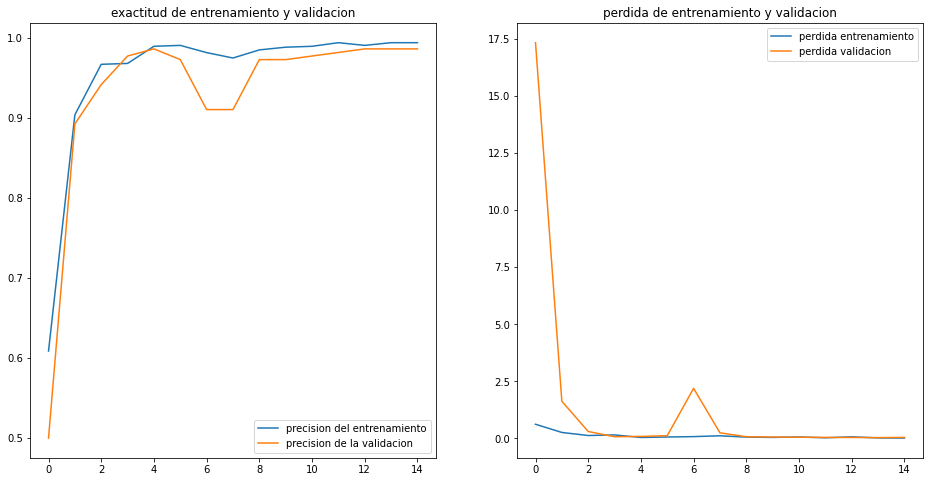

In [ ]:
precision = history.history['accuracy']
precision_val = history.history['val_accuracy']

perdida = history.history['loss']
perdida_val = history.history['val_loss']
 
epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, precision, label='precision del entrenamiento')
plt.plot(epochs_range, precision_val, label='precision de la validacion')
plt.legend(loc='lower right')
plt.title('exactitud de entrenamiento y validacion')

plt.subplot(1, 2, 2) 
plt.plot(epochs_range, perdida, label='perdida entrenamiento')
plt.plot(epochs_range, perdida_val, label='perdida validacion')
plt.legend(loc='upper right')
plt.title('perdida de entrenamiento y validacion')
plt.show()

# **PRUEBAS**

In [ ]:
model_dir = '/content/modelobostezos.h5'
modelo = load_model(model_dir)

In [ ]:
data_test, label_test = test_data_gen[0]
predictions=modelo.predict(data_test)

In [ ]:
prediccion = modelo.predict(data_test)
prediccion = tf.squeeze(prediccion).numpy()
prediccion_id = np.argmax(prediccion, axis=-1)

accuracy_score(label_test, prediccion_id)

0.9901960784313726